In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.integrate import cumulative_trapezoid
import time

# ==============================================================================
# --- 1. Setup: Constants & Thermodynamic Functions ---
# ==============================================================================

print("--- 1. Initializing constants and functions ---")

# --- Physical constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
Lv = 2.501e6
a_panel_a = 0.7  # Constant 'a' for panel (a)

# --- Thermodynamic utilities ---
def saturation_vapor_pressure(T):
    T_c = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_c) / (T_c + 243.5))
    return es_hPa * 100.0  # Pa

def saturation_specific_humidity(p, T):
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denom = p - (1.0 - epsilon) * es
    qs = np.divide(epsilon * es, denom, out=np.full_like(p, 1e-9), where=denom > 0)
    return np.maximum(qs, 1e-9)

def dqs_dT(p, T, dT=0.01):
    return (saturation_specific_humidity(p, T + dT)
            - saturation_specific_humidity(p, T - dT)) / (2 * dT)
            
def dqs_dp(p, T, dp=10.0):
    # Use a wider stencil for dp to avoid numerical issues
    dp = max(dp, 50.0)
    return (saturation_specific_humidity(p + dp, T)
            - saturation_specific_humidity(p - dp, T)) / (2 * dp)

def virtual_temperature(T, p):
    qs = saturation_specific_humidity(p, T)
    Tv = T * (1 + (1 / epsilon - 1) * qs)
    return np.maximum(Tv, 10.0)

def calculate_mse(T, p, z):
    qs = saturation_specific_humidity(p, T)
    return cpd * T + g * z + Lv * qs

# --- Profile Function 1: Moist Adiabat (Parcel) ---
def calculate_moist_adiabatic_profile(T_surf, p_surf, p_grid):
    n = len(p_grid)
    T_prof = np.full(n, np.nan); z_prof = np.full(n, np.nan)
    T_prof[0], z_prof[0] = T_surf, 0.0
    mse0 = calculate_mse(T_surf, p_grid[0], 0.0)
    for i in range(n - 1):
        T_cur, p_cur, z_cur = T_prof[i], p_grid[i], z_prof[i]
        p_next = p_grid[i + 1]
        if np.isnan(T_cur) or p_cur <= 0: break
        Tv = virtual_temperature(T_cur, p_cur)
        dz = - (Rd * Tv / p_cur) / g * (p_next - p_cur)
        z_next = z_cur + dz
        def resid(Tg): return calculate_mse(Tg, p_next, z_next) - mse0
        try:
            br = [150.0, T_cur + 5.0]
            if resid(br[0]) * resid(br[1]) > 0: break
            sol = root_scalar(resid, bracket=br, method='brentq', xtol=1e-3)
            if sol.converged:
                T_prof[i + 1], z_prof[i + 1] = sol.root, z_next
            else: break
        except: break
    return T_prof

# --- Profile Function 2: Entraining (Environment) ---
def calculate_entraining_profile(T_surf, p_surf, p_grid, a_val):
    n = len(p_grid)
    T_prof = np.full(n, np.nan)
    T_prof[0] = T_surf
    dp_step = p_grid[1] - p_grid[0] # Assumes constant dp

    for i in range(n - 1):
        T = T_prof[i]
        p = p_grid[i]
        if np.isnan(T): break

        cL = Lv * dqs_dT(p, T)
        alpha_d = Rd * T / p
        alpha_L = -Lv * dqs_dp(p, T, dp=abs(dp_step))
        
        num = (1.0 + a_val) * alpha_d + alpha_L
        den = (1.0 + a_val) * cpd + cL
        
        Gamma_e = np.divide(num, den, out=np.zeros_like(num), where=den!=0)

        T_prof[i + 1] = T + Gamma_e * dp_step
    return T_prof

# --- Helper to get Gamma_m ---
def get_gamma_m(T, p, dp_step):
    cL = Lv * dqs_dT(p, T)
    alpha_d = Rd * T / p
    alpha_L = -Lv * dqs_dp(p, T, dp=abs(dp_step))
    num = alpha_d + alpha_L
    den = cpd + cL
    return np.divide(num, den, out=np.zeros_like(num), where=den!=0)

# --- Helper to get Gamma_e ---
def get_gamma_e(T, p, a_val, dp_step):
    cL = Lv * dqs_dT(p, T)
    alpha_d = Rd * T / p
    alpha_L = -Lv * dqs_dp(p, T, dp=abs(dp_step))
    num = (1.0 + a_val) * alpha_d + alpha_L
    den = (1.0 + a_val) * cpd + cL
    return np.divide(num, den, out=np.zeros_like(num), where=den!=0)

# --- Helper to get Gamma_m profile ---
def get_gamma_m_profile(T_prof, p_grid):
    n = len(p_grid)
    Gamma_m_prof = np.full(n, np.nan)
    dp_step = p_grid[1] - p_grid[0]
    for i in range(n):
        T, p = T_prof[i], p_grid[i]
        if np.isnan(T): continue
        Gamma_m_prof[i] = get_gamma_m(T, p, dp_step)
    return Gamma_m_prof

# --- Helper to get Gamma_e profile ---
def get_gamma_e_profile(T_prof, p_grid, a_val):
    n = len(p_grid)
    Gamma_e_prof = np.full(n, np.nan)
    dp_step = p_grid[1] - p_grid[0]
    for i in range(n):
        T, p = T_prof[i], p_grid[i]
        if np.isnan(T): continue
        Gamma_e_prof[i] = get_gamma_e(T, p, a_val, dp_step)
    return Gamma_e_prof
    
# --- Helper function for stable root interpolation ---
def find_interpolated_root(y_slice, x_vals, y_slice_for_guess=None, guess_mode='min'):
    if np.all(np.isnan(y_slice)):
        return np.nan
    sign_changes = np.where((y_slice[:-1] * y_slice[1:]) < 0)[0]
    k_all = []
    for k in sign_changes:
        if np.isfinite(y_slice[k]) and np.isfinite(y_slice[k + 1]):
            k_all.append(k)
    if not k_all:
        return np.nan
    T_candidates = []
    for k in k_all:
        T0, T1 = x_vals[k], x_vals[k + 1]
        y0, y1 = y_slice[k], y_slice[k + 1]
        if y1 == y0: continue
        T_root = T0 - y0 * (T1 - T0) / (y1 - y0)
        T_candidates.append(T_root)
    if not T_candidates:
        return np.nan
    if len(T_candidates) == 1:
        return T_candidates[0]
    if y_slice_for_guess is None:
        y_slice_for_guess = y_slice
    if guess_mode == 'min':
        j_guess = np.nanargmin(y_slice_for_guess)
    elif guess_mode == 'max':
        j_guess = np.nanargmax(y_slice_for_guess)
    else: # 'abs_min'
        j_guess = np.nanargmin(np.abs(y_slice_for_guess))
    T_guess = x_vals[j_guess]
    T_best = min(T_candidates, key=lambda T: abs(T - T_guess))
    return T_best

# ==============================================================================
# --- 2. Panel (a) Calculation (p vs. T_s) ---
# ==============================================================================

print("--- 2. Starting Panel (a) calculation (p vs. T_s) ---")
t0 = time.time()

# --- Grid & storage ---
T_surf_vals = np.arange(270, 320.1, 0.5)
p_s, p_top, dp_a = 100000.0, 10000.0, -500.0
p_grid_a = np.arange(p_s, p_top + dp_a, dp_a)
n_p_a, n_t = len(p_grid_a), len(T_surf_vals)

cL_grid_a = np.full((n_p_a, n_t), np.nan)
buoyancy_proxy_grid_a = np.full((n_p_a, n_t), np.nan) # (Tp - Te) / Te
integrand_grid_a = np.full((n_p_a, n_t), np.nan) # (Ge - Gm)

for j, Ts in enumerate(T_surf_vals):
    if j % 20 == 0:
        print(f"  Panel (a): Calculating for T_s = {Ts:.1f} K...")

    Tprof_p = calculate_moist_adiabatic_profile(Ts, p_s, p_grid_a)
    if np.isnan(Tprof_p[-1]): continue

    Tprof_e = calculate_entraining_profile(Ts, p_s, p_grid_a, a_panel_a)
    if np.isnan(Tprof_e[-1]): continue
    
    cL_vals = Lv * dqs_dT(p_grid_a, Tprof_p)
    
    Gamma_m_prof = get_gamma_m_profile(Tprof_p, p_grid_a)
    Gamma_e_prof = get_gamma_e_profile(Tprof_e, p_grid_a, a_panel_a)

    integrand_prof = Gamma_e_prof - Gamma_m_prof
    I_profile = cumulative_trapezoid(integrand_prof, x=p_grid_a, initial=0.0)

    B_proxy_profile = np.divide(I_profile, Tprof_e, out=np.zeros_like(I_profile), where=Tprof_e > 0)

    cL_grid_a[:, j] = cL_vals
    buoyancy_proxy_grid_a[:, j] = B_proxy_profile
    integrand_grid_a[:, j] = integrand_prof

print(f"Panel (a) calculation done in {time.time() - t0:.1f}s")

# --- 2b. Find Extrema for Panel (a) ---
print("--- 2b. Finding extrema for Panel (a) ---")
dT_s = T_surf_vals[1] - T_surf_vals[0]
grad_buoyancy_proxy_grid_a = np.gradient(buoyancy_proxy_grid_a, dT_s, axis=1)
grad_integrand_grid_a = np.gradient(integrand_grid_a, dT_s, axis=1)

p_grid_a_hpa = p_grid_a / 100.0
Ts_peak_romps_a = np.full(n_p_a, np.nan)
Ts_peak_derived_a = np.full(n_p_a, np.nan)
Ts_peak_actual_B_a = np.full(n_p_a, np.nan)
Ts_peak_integrand_a = np.full(n_p_a, np.nan) # New line

for i in range(n_p_a):
    y_slice_romps = cL_grid_a[i, :] - cpd
    Ts_peak_romps_a[i] = find_interpolated_root(y_slice_romps, T_surf_vals, guess_mode='abs_min')

    y_slice_derived = cL_grid_a[i, :] - (cpd * np.sqrt(1.0 + a_panel_a))
    Ts_peak_derived_a[i] = find_interpolated_root(y_slice_derived, T_surf_vals, guess_mode='abs_min')

    grad_slice_B = grad_buoyancy_proxy_grid_a[i, :]
    Ts_peak_actual_B_a[i] = find_interpolated_root(grad_slice_B, T_surf_vals, 
        y_slice_for_guess=buoyancy_proxy_grid_a[i, :], guess_mode='max')
        
    grad_slice_int = grad_integrand_grid_a[i, :]
    Ts_peak_integrand_a[i] = find_interpolated_root(grad_slice_int, T_surf_vals, 
        y_slice_for_guess=integrand_grid_a[i, :], guess_mode='max')

Ts_peak_actual_B_a[0] = np.nan # Fix for p=ps
Ts_peak_integrand_a[0] = np.nan

# ==============================================================================
# --- 3. Panel (b) Calculation (a vs. T_s) at p = 500 hPa ---
# ==============================================================================

print("--- 3. Starting Panel (b) calculation (a vs. T_s) ---")
t0 = time.time()

a_vals_b = np.arange(0, 5.01, 0.05)
n_a_b = len(a_vals_b)

p_target_b = 50000.0
dp_b = -500.0 # Coarse grid for speed, as requested
p_grid_b = np.arange(p_s, p_top + dp_b, dp_b)
# Ensure p_target is in the grid
if p_target_b not in p_grid_b:
    p_grid_b = np.sort(np.unique(np.concatenate((p_grid_b, [p_target_b]))))[::-1]
i_p_b = np.argmin(np.abs(p_grid_b - p_target_b))

cL_at_p_target_vs_Ts_b = np.full(n_t, np.nan)
buoyancy_proxy_grid_b = np.full((n_a_b, n_t), np.nan)
integrand_grid_b = np.full((n_a_b, n_t), np.nan)

for j, Ts in enumerate(T_surf_vals):
    if j % 20 == 0:
        print(f"  Panel (b): Calculating for T_s = {Ts:.1f} K...")

    Tprof_p = calculate_moist_adiabatic_profile(Ts, p_s, p_grid_b)
    if np.isnan(Tprof_p[i_p_b]): continue
    
    Gamma_m_prof = get_gamma_m_profile(Tprof_p, p_grid_b)
    
    T_p_at_p = Tprof_p[i_p_b]
    cL_at_p = Lv * dqs_dT(p_target_b, T_p_at_p)
    cL_at_p_target_vs_Ts_b[j] = cL_at_p

    for i, a in enumerate(a_vals_b):
        Tprof_e = calculate_entraining_profile(Ts, p_s, p_grid_b, a)
        T_e_at_p = Tprof_e[i_p_b]
        if np.isnan(T_e_at_p): continue
        
        Gamma_e_prof = get_gamma_e_profile(Tprof_e, p_grid_b, a)
        
        integrand_prof = Gamma_e_prof - Gamma_m_prof
        I_profile = cumulative_trapezoid(integrand_prof, x=p_grid_b, initial=0.0)
        
        I_at_p = I_profile[i_p_b]
        
        B_proxy_at_p = np.divide(I_at_p, T_e_at_p, out=np.zeros_like(I_at_p), where=T_e_at_p > 0)
        
        buoyancy_proxy_grid_b[i, j] = B_proxy_at_p
        integrand_grid_b[i, j] = integrand_prof[i_p_b]

print(f"Panel (b) calculation done in {time.time() - t0:.1f}s")

# --- 3b. Find Extrema for Panel (b) ---
print("--- 3b. Finding extrema for Panel (b) ---")
grad_buoyancy_proxy_grid_b = np.gradient(buoyancy_proxy_grid_b, dT_s, axis=1)
grad_integrand_grid_b = np.gradient(integrand_grid_b, dT_s, axis=1)

Ts_peak_derived_vs_a_b = np.full(n_a_b, np.nan)
Ts_peak_actual_B_vs_a_b = np.full(n_a_b, np.nan)
Ts_peak_integrand_vs_a_b = np.full(n_a_b, np.nan) # New line

y_slice_romps = cL_at_p_target_vs_Ts_b - cpd
Ts_peak_romps_const_b = find_interpolated_root(y_slice_romps, T_surf_vals, guess_mode='abs_min')
print(f"  Panel (b) Romps criterion (cL=cpd) at 500hPa gives Ts = {Ts_peak_romps_const_b:.2f} K")

for i, a in enumerate(a_vals_b):
    target_cL = cpd * np.sqrt(1.0 + a)
    y_slice_derived = cL_at_p_target_vs_Ts_b - target_cL
    Ts_peak_derived_vs_a_b[i] = find_interpolated_root(y_slice_derived, T_surf_vals, guess_mode='abs_min')

    grad_slice_B = grad_buoyancy_proxy_grid_b[i, :]
    Ts_peak_actual_B_vs_a_b[i] = find_interpolated_root(grad_slice_B, T_surf_vals,
        y_slice_for_guess=buoyancy_proxy_grid_b[i, :], guess_mode='max')
        
    grad_slice_int = grad_integrand_grid_b[i, :]
    Ts_peak_integrand_vs_a_b[i] = find_interpolated_root(grad_slice_int, T_surf_vals,
        y_slice_for_guess=integrand_grid_b[i, :], guess_mode='max')

print(f"Extrema finding done in {time.time() - t0:.1f}s")



--- 1. Initializing constants and functions ---
--- 2. Starting Panel (a) calculation (p vs. T_s) ---
  Panel (a): Calculating for T_s = 270.0 K...
  Panel (a): Calculating for T_s = 280.0 K...
  Panel (a): Calculating for T_s = 290.0 K...
  Panel (a): Calculating for T_s = 300.0 K...
  Panel (a): Calculating for T_s = 310.0 K...
  Panel (a): Calculating for T_s = 320.0 K...
Panel (a) calculation done in 2.0s
--- 2b. Finding extrema for Panel (a) ---
--- 3. Starting Panel (b) calculation (a vs. T_s) ---
  Panel (b): Calculating for T_s = 270.0 K...
  Panel (b): Calculating for T_s = 280.0 K...
  Panel (b): Calculating for T_s = 290.0 K...
  Panel (b): Calculating for T_s = 300.0 K...
  Panel (b): Calculating for T_s = 310.0 K...
  Panel (b): Calculating for T_s = 320.0 K...
Panel (b) calculation done in 80.9s
--- 3b. Finding extrema for Panel (b) ---
  Panel (b) Romps criterion (cL=cpd) at 500hPa gives Ts = 295.44 K
Extrema finding done in 80.9s


--- 4. Generating Figure 6 (Combined) ---


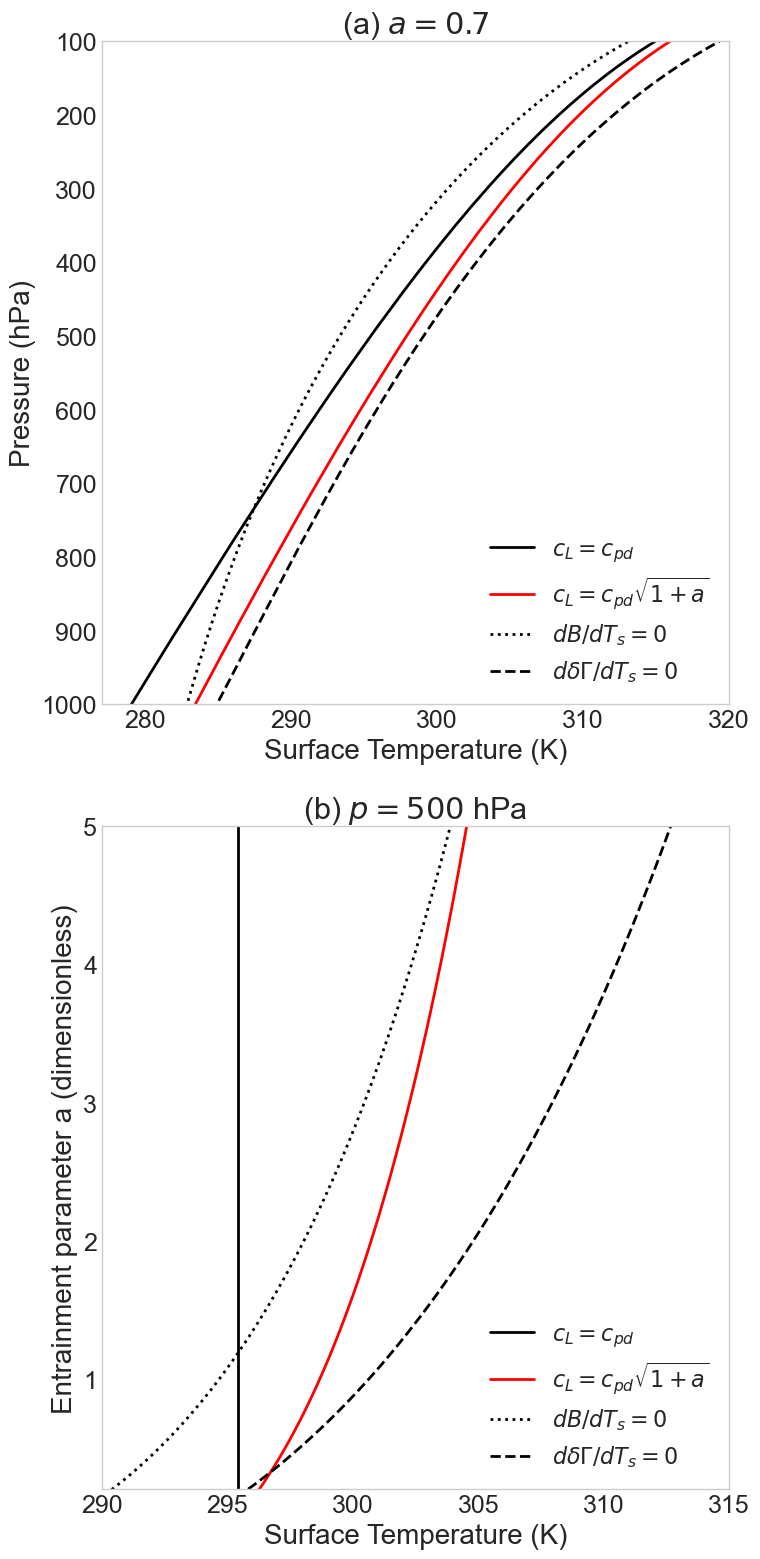

Figure 6 saved as fig-6.png


In [2]:
# ==============================================================================
# --- 4. Plotting (Figure 6 - Combined) ---
# ==============================================================================

print("--- 4. Generating Figure 6 (Combined) ---")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 22,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 16
})

# Create 2x1 subplot grid
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 16))

# --- Panel (a): p vs Ts ---
ax1.plot(Ts_peak_romps_a, p_grid_a_hpa, '-', color='black', lw=2,
        label=r'$c_L = c_{pd}$')
ax1.plot(Ts_peak_derived_a, p_grid_a_hpa, '-', color='red', lw=2,
        label=r'$c_L = c_{pd}\sqrt{1+a}$')
ax1.plot(Ts_peak_actual_B_a, p_grid_a_hpa, ':', color='black', lw=2,
        label=r'$dB/dT_s = 0$')
ax1.plot(Ts_peak_integrand_a, p_grid_a_hpa, '--', color='black', lw=2,
        label=r'$d\delta\Gamma/dT_s = 0$')

ax1.set_xlabel('Surface Temperature (K)')
ax1.set_ylabel('Pressure (hPa)')
ax1.invert_yaxis()
ax1.set_xlim(right=320)
ax1.set_ylim(1000, 100)
p_levels_hpa_a = np.arange(100, 1001, 100)
ax1.set_yticks(p_levels_hpa_a)
ax1.set_title(r'(a) $a=0.7$')
ax1.legend(loc='lower right')
ax1.grid(False)

# --- Panel (b): a vs Ts ---
ax2.axvline(Ts_peak_romps_const_b, color='black', ls='-', lw=2,
           label=r'$c_L = c_{pd}$')
ax2.plot(Ts_peak_derived_vs_a_b, a_vals_b, color='red', ls='-', lw=2,
        label=r'$c_L = c_{pd}\sqrt{1+a}$')
ax2.plot(Ts_peak_actual_B_vs_a_b, a_vals_b, color='black', ls=':', lw=2,
        label=r'$dB/dT_s = 0$')
ax2.plot(Ts_peak_integrand_vs_a_b, a_vals_b, color='black', ls='--', lw=2,
        label=r'$d\delta\Gamma/dT_s = 0$')

ax2.set_xlabel('Surface Temperature (K)')
ax2.set_ylabel('Entrainment parameter a (dimensionless)')
# Apply user's specified limits and ticks
ax2.set_ylim(0.2, 5)
ax2.set_xlim(290, 315)
ax2.set_xticks(np.arange(290, 316, 5))
ax2.set_title(r'(b) $p=500$ hPa')
ax2.legend(loc='lower right')
ax2.grid(False)

plt.tight_layout()
plt.savefig("fig-6.png", dpi=600, bbox_inches='tight')
plt.show()
print("Figure 6 saved as fig-6.png")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.integrate import cumulative_trapezoid
import time

# ==============================================================================
# --- 1. Setup: Constants & Thermodynamic Functions ---
# ==============================================================================

print("--- 1. Initializing constants and functions ---")

# --- Physical constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
Lv = 2.501e6

# --- Thermodynamic utilities ---
def saturation_vapor_pressure(T):
    T_c = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_c) / (T_c + 243.5))
    return es_hPa * 100.0  # Pa

def saturation_specific_humidity(p, T):
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denom = p - (1.0 - epsilon) * es
    qs = np.divide(epsilon * es, denom, out=np.full_like(p, 1e-9), where=denom > 0)
    return np.maximum(qs, 1e-9)

def dqs_dT(p, T, dT=0.01):
    return (saturation_specific_humidity(p, T + dT)
            - saturation_specific_humidity(p, T - dT)) / (2 * dT)
            
def dqs_dp(p, T, dp=10.0):
    # Use a wider stencil for dp to avoid numerical issues
    dp = max(dp, 50.0)
    return (saturation_specific_humidity(p + dp, T)
            - saturation_specific_humidity(p - dp, T)) / (2 * dp)

def virtual_temperature(T, p):
    qs = saturation_specific_humidity(p, T)
    Tv = T * (1 + (1 / epsilon - 1) * qs)
    return np.maximum(Tv, 10.0)

def calculate_mse(T, p, z):
    qs = saturation_specific_humidity(p, T)
    return cpd * T + g * z + Lv * qs

# --- Profile Function 1: Moist Adiabat (Parcel) ---
def calculate_moist_adiabatic_profile(T_surf, p_surf, p_grid):
    n = len(p_grid)
    T_prof = np.full(n, np.nan); z_prof = np.full(n, np.nan)
    T_prof[0], z_prof[0] = T_surf, 0.0
    mse0 = calculate_mse(T_surf, p_grid[0], 0.0)
    for i in range(n - 1):
        T_cur, p_cur, z_cur = T_prof[i], p_grid[i], z_prof[i]
        p_next = p_grid[i + 1]
        if np.isnan(T_cur) or p_cur <= 0: break
        Tv = virtual_temperature(T_cur, p_cur)
        dz = - (Rd * Tv / p_cur) / g * (p_next - p_cur)
        z_next = z_cur + dz
        def resid(Tg): return calculate_mse(Tg, p_next, z_next) - mse0
        try:
            br = [150.0, T_cur + 5.0]
            if resid(br[0]) * resid(br[1]) > 0: break
            sol = root_scalar(resid, bracket=br, method='brentq', xtol=1e-3)
            if sol.converged:
                T_prof[i + 1], z_prof[i + 1] = sol.root, z_next
            else: break
        except: break
    return T_prof

# --- Profile Function 2: Entraining (Environment) ---
def calculate_entraining_profile(T_surf, p_surf, p_grid, a_val):
    n = len(p_grid)
    T_prof = np.full(n, np.nan)
    T_prof[0] = T_surf
    if n < 2: return T_prof
    dp_step = p_grid[1] - p_grid[0] # Assumes constant dp

    for i in range(n - 1):
        T = T_prof[i]
        p = p_grid[i]
        if np.isnan(T): break

        cL = Lv * dqs_dT(p, T)
        alpha_d = Rd * T / p
        alpha_L = -Lv * dqs_dp(p, T, dp=abs(dp_step))
        
        num = (1.0 + a_val) * alpha_d + alpha_L
        den = (1.0 + a_val) * cpd + cL
        
        Gamma_e = np.divide(num, den, out=np.zeros_like(num), where=den!=0)

        T_prof[i + 1] = T + Gamma_e * dp_step
    return T_prof

# --- Helper to get Gamma_m ---
def get_gamma_m(T, p, dp_step):
    cL = Lv * dqs_dT(p, T)
    alpha_d = Rd * T / p
    alpha_L = -Lv * dqs_dp(p, T, dp=abs(dp_step))
    num = alpha_d + alpha_L
    den = cpd + cL
    return np.divide(num, den, out=np.zeros_like(num), where=den!=0)

# --- Helper to get Gamma_e ---
def get_gamma_e(T, p, a_val, dp_step):
    cL = Lv * dqs_dT(p, T)
    alpha_d = Rd * T / p
    alpha_L = -Lv * dqs_dp(p, T, dp=abs(dp_step))
    num = (1.0 + a_val) * alpha_d + alpha_L
    den = (1.0 + a_val) * cpd + cL
    return np.divide(num, den, out=np.zeros_like(num), where=den!=0)

# --- Helper to get Gamma_m profile ---
def get_gamma_m_profile(T_prof, p_grid):
    n = len(p_grid)
    if n < 2: return np.full(n, np.nan)
    Gamma_m_prof = np.full(n, np.nan)
    dp_step = p_grid[1] - p_grid[0]
    for i in range(n):
        T, p = T_prof[i], p_grid[i]
        if np.isnan(T): continue
        Gamma_m_prof[i] = get_gamma_m(T, p, dp_step)
    return Gamma_m_prof

# --- Helper to get Gamma_e profile ---
def get_gamma_e_profile(T_prof, p_grid, a_val):
    n = len(p_grid)
    if n < 2: return np.full(n, np.nan)
    Gamma_e_prof = np.full(n, np.nan)
    dp_step = p_grid[1] - p_grid[0]
    for i in range(n):
        T, p = T_prof[i], p_grid[i]
        if np.isnan(T): continue
        Gamma_e_prof[i] = get_gamma_e(T, p, a_val, dp_step)
    return Gamma_e_prof
    
# --- Helper function for stable root interpolation ---
def find_interpolated_root(y_slice, x_vals, y_slice_for_guess=None, guess_mode='min'):
    if np.all(np.isnan(y_slice)):
        return np.nan
    sign_changes = np.where((y_slice[:-1] * y_slice[1:]) < 0)[0]
    k_all = []
    for k in sign_changes:
        if np.isfinite(y_slice[k]) and np.isfinite(y_slice[k + 1]):
            k_all.append(k)
    if not k_all:
        return np.nan
    T_candidates = []
    for k in k_all:
        T0, T1 = x_vals[k], x_vals[k + 1]
        y0, y1 = y_slice[k], y_slice[k + 1]
        if y1 == y0: continue
        T_root = T0 - y0 * (T1 - T0) / (y1 - y0)
        T_candidates.append(T_root)
    if not T_candidates:
        return np.nan
    if len(T_candidates) == 1:
        return T_candidates[0]
    if y_slice_for_guess is None:
        y_slice_for_guess = y_slice
    if guess_mode == 'min':
        j_guess = np.nanargmin(y_slice_for_guess)
    elif guess_mode == 'max':
        j_guess = np.nanargmax(y_slice_for_guess)
    else: # 'abs_min'
        j_guess = np.nanargmin(np.abs(y_slice_for_guess))
    T_guess = x_vals[j_guess]
    T_best = min(T_candidates, key=lambda T: abs(T - T_guess))
    return T_best

# --- Shared Grids ---
T_surf_vals = np.arange(270, 320.1, 0.5)
n_t = len(T_surf_vals)
p_s, p_top = 100000.0, 10000.0

# ==============================================================================
# --- 2. Panel (a) Calculation (p vs. T_s, a=0.2) ---
# ==============================================================================

print("--- 2. Starting Panel (a) calculation (p vs. T_s, a=0.2) ---")
t0 = time.time()

a_panel_a = 0.2
dp_a = -500.0
p_grid_a = np.arange(p_s, p_top + dp_a, dp_a)
n_p_a = len(p_grid_a)

cL_grid_a = np.full((n_p_a, n_t), np.nan)
buoyancy_proxy_grid_a = np.full((n_p_a, n_t), np.nan) # (Tp - Te) / Te
integrand_grid_a = np.full((n_p_a, n_t), np.nan) # (Ge - Gm)

for j, Ts in enumerate(T_surf_vals):
    if j % 20 == 0:
        print(f"  Panel (a): Calculating for T_s = {Ts:.1f} K...")

    Tprof_p = calculate_moist_adiabatic_profile(Ts, p_s, p_grid_a)
    if np.isnan(Tprof_p[-1]): continue

    Tprof_e = calculate_entraining_profile(Ts, p_s, p_grid_a, a_panel_a)
    if np.isnan(Tprof_e[-1]): continue
    
    cL_vals = Lv * dqs_dT(p_grid_a, Tprof_p)
    
    Gamma_m_prof = get_gamma_m_profile(Tprof_p, p_grid_a)
    Gamma_e_prof = get_gamma_e_profile(Tprof_e, p_grid_a, a_panel_a)

    integrand_prof = Gamma_e_prof - Gamma_m_prof
    I_profile = cumulative_trapezoid(integrand_prof, x=p_grid_a, initial=0.0)

    B_proxy_profile = np.divide(I_profile, Tprof_e, out=np.zeros_like(I_profile), where=Tprof_e > 0)

    cL_grid_a[:, j] = cL_vals
    buoyancy_proxy_grid_a[:, j] = B_proxy_profile
    integrand_grid_a[:, j] = integrand_prof

print(f"Panel (a) calculation done in {time.time() - t0:.1f}s")

# --- 2b. Find Extrema for Panel (a) ---
print("--- 2b. Finding extrema for Panel (a) ---")
dT_s = T_surf_vals[1] - T_surf_vals[0]
grad_buoyancy_proxy_grid_a = np.gradient(buoyancy_proxy_grid_a, dT_s, axis=1)
grad_integrand_grid_a = np.gradient(integrand_grid_a, dT_s, axis=1)

p_grid_a_hpa = p_grid_a / 100.0
Ts_peak_romps_a = np.full(n_p_a, np.nan)
Ts_peak_derived_a = np.full(n_p_a, np.nan)
Ts_peak_actual_B_a = np.full(n_p_a, np.nan)
Ts_peak_integrand_a = np.full(n_p_a, np.nan)

for i in range(n_p_a):
    y_slice_romps = cL_grid_a[i, :] - cpd
    Ts_peak_romps_a[i] = find_interpolated_root(y_slice_romps, T_surf_vals, guess_mode='abs_min')

    y_slice_derived = cL_grid_a[i, :] - (cpd * np.sqrt(1.0 + a_panel_a))
    Ts_peak_derived_a[i] = find_interpolated_root(y_slice_derived, T_surf_vals, guess_mode='abs_min')

    grad_slice_B = grad_buoyancy_proxy_grid_a[i, :]
    Ts_peak_actual_B_a[i] = find_interpolated_root(grad_slice_B, T_surf_vals, 
        y_slice_for_guess=buoyancy_proxy_grid_a[i, :], guess_mode='max')
        
    grad_slice_int = grad_integrand_grid_a[i, :]
    Ts_peak_integrand_a[i] = find_interpolated_root(grad_slice_int, T_surf_vals, 
        y_slice_for_guess=integrand_grid_a[i, :], guess_mode='max')

Ts_peak_actual_B_a[0] = np.nan # Fix for p=ps
Ts_peak_integrand_a[0] = np.nan

# ==============================================================================
# --- 3. Panel (b) Calculation (p vs. T_s, a=0.7) ---
# ==============================================================================

print("--- 3. Starting Panel (b) calculation (p vs. T_s, a=0.7) ---")
t0 = time.time()

a_panel_b = 0.7
dp_b = -500.0 # Using same resolution as panel (a)
p_grid_b = np.arange(p_s, p_top + dp_b, dp_b)
n_p_b = len(p_grid_b)

cL_grid_b = np.full((n_p_b, n_t), np.nan)
buoyancy_proxy_grid_b = np.full((n_p_b, n_t), np.nan) # (Tp - Te) / Te
integrand_grid_b = np.full((n_p_b, n_t), np.nan) # (Ge - Gm)

for j, Ts in enumerate(T_surf_vals):
    if j % 20 == 0:
        print(f"  Panel (b): Calculating for T_s = {Ts:.1f} K...")

    Tprof_p = calculate_moist_adiabatic_profile(Ts, p_s, p_grid_b)
    if np.isnan(Tprof_p[-1]): continue

    Tprof_e = calculate_entraining_profile(Ts, p_s, p_grid_b, a_panel_b)
    if np.isnan(Tprof_e[-1]): continue
    
    cL_vals = Lv * dqs_dT(p_grid_b, Tprof_p)
    
    Gamma_m_prof = get_gamma_m_profile(Tprof_p, p_grid_b)
    Gamma_e_prof = get_gamma_e_profile(Tprof_e, p_grid_b, a_panel_b)

    integrand_prof = Gamma_e_prof - Gamma_m_prof
    I_profile = cumulative_trapezoid(integrand_prof, x=p_grid_b, initial=0.0)

    B_proxy_profile = np.divide(I_profile, Tprof_e, out=np.zeros_like(I_profile), where=Tprof_e > 0)

    cL_grid_b[:, j] = cL_vals
    buoyancy_proxy_grid_b[:, j] = B_proxy_profile
    integrand_grid_b[:, j] = integrand_prof

print(f"Panel (b) calculation done in {time.time() - t0:.1f}s")

# --- 3b. Find Extrema for Panel (b) ---
print("--- 3b. Finding extrema for Panel (b) ---")
grad_buoyancy_proxy_grid_b = np.gradient(buoyancy_proxy_grid_b, dT_s, axis=1)
grad_integrand_grid_b = np.gradient(integrand_grid_b, dT_s, axis=1)

p_grid_b_hpa = p_grid_b / 100.0
Ts_peak_romps_b = np.full(n_p_b, np.nan)
Ts_peak_derived_b = np.full(n_p_b, np.nan)
Ts_peak_actual_B_b = np.full(n_p_b, np.nan)
Ts_peak_integrand_b = np.full(n_p_b, np.nan) # New line

for i in range(n_p_b):
    y_slice_romps = cL_grid_b[i, :] - cpd
    Ts_peak_romps_b[i] = find_interpolated_root(y_slice_romps, T_surf_vals, guess_mode='abs_min')

    y_slice_derived = cL_grid_b[i, :] - (cpd * np.sqrt(1.0 + a_panel_b))
    Ts_peak_derived_b[i] = find_interpolated_root(y_slice_derived, T_surf_vals, guess_mode='abs_min')

    grad_slice_B = grad_buoyancy_proxy_grid_b[i, :]
    Ts_peak_actual_B_b[i] = find_interpolated_root(grad_slice_B, T_surf_vals, 
        y_slice_for_guess=buoyancy_proxy_grid_b[i, :], guess_mode='max')
        
    grad_slice_int = grad_integrand_grid_b[i, :]
    Ts_peak_integrand_b[i] = find_interpolated_root(grad_slice_int, T_surf_vals, 
        y_slice_for_guess=integrand_grid_b[i, :], guess_mode='max')

Ts_peak_actual_B_b[0] = np.nan # Fix for p=ps
Ts_peak_integrand_b[0] = np.nan


# ==============================================================================
# --- 4. Panel (c) Calculation (a vs. T_s) at p = 500 hPa ---
# ==============================================================================

print("--- 4. Starting Panel (c) calculation (a vs. T_s) ---")
t0 = time.time()

a_vals_c = np.arange(0, 5.01, 0.05)
n_a_c = len(a_vals_c)

p_target_c = 50000.0
dp_c = -500.0 # Coarse grid for speed, as requested
p_grid_c = np.arange(p_s, p_top + dp_c, dp_c)
# Ensure p_target is in the grid
if p_target_c not in p_grid_c:
    p_grid_c = np.sort(np.unique(np.concatenate((p_grid_c, [p_target_c]))))[::-1]
i_p_c = np.argmin(np.abs(p_grid_c - p_target_c))

cL_at_p_target_vs_Ts_c = np.full(n_t, np.nan)
buoyancy_proxy_grid_c = np.full((n_a_c, n_t), np.nan)
integrand_grid_c = np.full((n_a_c, n_t), np.nan)

for j, Ts in enumerate(T_surf_vals):
    if j % 20 == 0:
        print(f"  Panel (c): Calculating for T_s = {Ts:.1f} K...")

    Tprof_p = calculate_moist_adiabatic_profile(Ts, p_s, p_grid_c)
    if np.isnan(Tprof_p[i_p_c]): continue
    
    Gamma_m_prof = get_gamma_m_profile(Tprof_p, p_grid_c)
    
    T_p_at_p = Tprof_p[i_p_c]
    cL_at_p = Lv * dqs_dT(p_target_c, T_p_at_p)
    cL_at_p_target_vs_Ts_c[j] = cL_at_p

    for i, a in enumerate(a_vals_c):
        Tprof_e = calculate_entraining_profile(Ts, p_s, p_grid_c, a)
        T_e_at_p = Tprof_e[i_p_c]
        if np.isnan(T_e_at_p): continue
        
        Gamma_e_prof = get_gamma_e_profile(Tprof_e, p_grid_c, a)
        
        integrand_prof = Gamma_e_prof - Gamma_m_prof
        I_profile = cumulative_trapezoid(integrand_prof, x=p_grid_c, initial=0.0)
        
        I_at_p = I_profile[i_p_c]
        
        B_proxy_at_p = np.divide(I_at_p, T_e_at_p, out=np.zeros_like(I_at_p), where=T_e_at_p > 0)
        
        buoyancy_proxy_grid_c[i, j] = B_proxy_at_p
        integrand_grid_c[i, j] = integrand_prof[i_p_c]

print(f"Panel (c) calculation done in {time.time() - t0:.1f}s")

# --- 4b. Find Extrema for Panel (c) ---
print("--- 4b. Finding extrema for Panel (c) ---")
grad_buoyancy_proxy_grid_c = np.gradient(buoyancy_proxy_grid_c, dT_s, axis=1)
grad_integrand_grid_c = np.gradient(integrand_grid_c, dT_s, axis=1)

Ts_peak_derived_vs_a_c = np.full(n_a_c, np.nan)
Ts_peak_actual_B_vs_a_c = np.full(n_a_c, np.nan)
Ts_peak_integrand_vs_a_c = np.full(n_a_c, np.nan) # New line

y_slice_romps = cL_at_p_target_vs_Ts_c - cpd
Ts_peak_romps_const_c = find_interpolated_root(y_slice_romps, T_surf_vals, guess_mode='abs_min')
print(f"  Panel (c) Romps criterion (cL=cpd) at 500hPa gives Ts = {Ts_peak_romps_const_c:.2f} K")

for i, a in enumerate(a_vals_c):
    target_cL = cpd * np.sqrt(1.0 + a)
    y_slice_derived = cL_at_p_target_vs_Ts_c - target_cL
    Ts_peak_derived_vs_a_c[i] = find_interpolated_root(y_slice_derived, T_surf_vals, guess_mode='abs_min')

    grad_slice_B = grad_buoyancy_proxy_grid_c[i, :]
    Ts_peak_actual_B_vs_a_c[i] = find_interpolated_root(grad_slice_B, T_surf_vals,
        y_slice_for_guess=buoyancy_proxy_grid_c[i, :], guess_mode='max')
        
    grad_slice_int = grad_integrand_grid_c[i, :]
    Ts_peak_integrand_vs_a_c[i] = find_interpolated_root(grad_slice_int, T_surf_vals,
        y_slice_for_guess=integrand_grid_c[i, :], guess_mode='max')

print(f"Extrema finding done in {time.time() - t0:.1f}s")



--- 1. Initializing constants and functions ---
--- 2. Starting Panel (a) calculation (p vs. T_s, a=0.2) ---
  Panel (a): Calculating for T_s = 270.0 K...
  Panel (a): Calculating for T_s = 280.0 K...
  Panel (a): Calculating for T_s = 290.0 K...
  Panel (a): Calculating for T_s = 300.0 K...
  Panel (a): Calculating for T_s = 310.0 K...
  Panel (a): Calculating for T_s = 320.0 K...
Panel (a) calculation done in 2.1s
--- 2b. Finding extrema for Panel (a) ---
--- 3. Starting Panel (b) calculation (p vs. T_s, a=0.7) ---
  Panel (b): Calculating for T_s = 270.0 K...
  Panel (b): Calculating for T_s = 280.0 K...
  Panel (b): Calculating for T_s = 290.0 K...
  Panel (b): Calculating for T_s = 300.0 K...
  Panel (b): Calculating for T_s = 310.0 K...
  Panel (b): Calculating for T_s = 320.0 K...
Panel (b) calculation done in 2.2s
--- 3b. Finding extrema for Panel (b) ---
--- 4. Starting Panel (c) calculation (a vs. T_s) ---
  Panel (c): Calculating for T_s = 270.0 K...
  Panel (c): Calculating

--- 5. Generating Figure 6 (Combined) ---


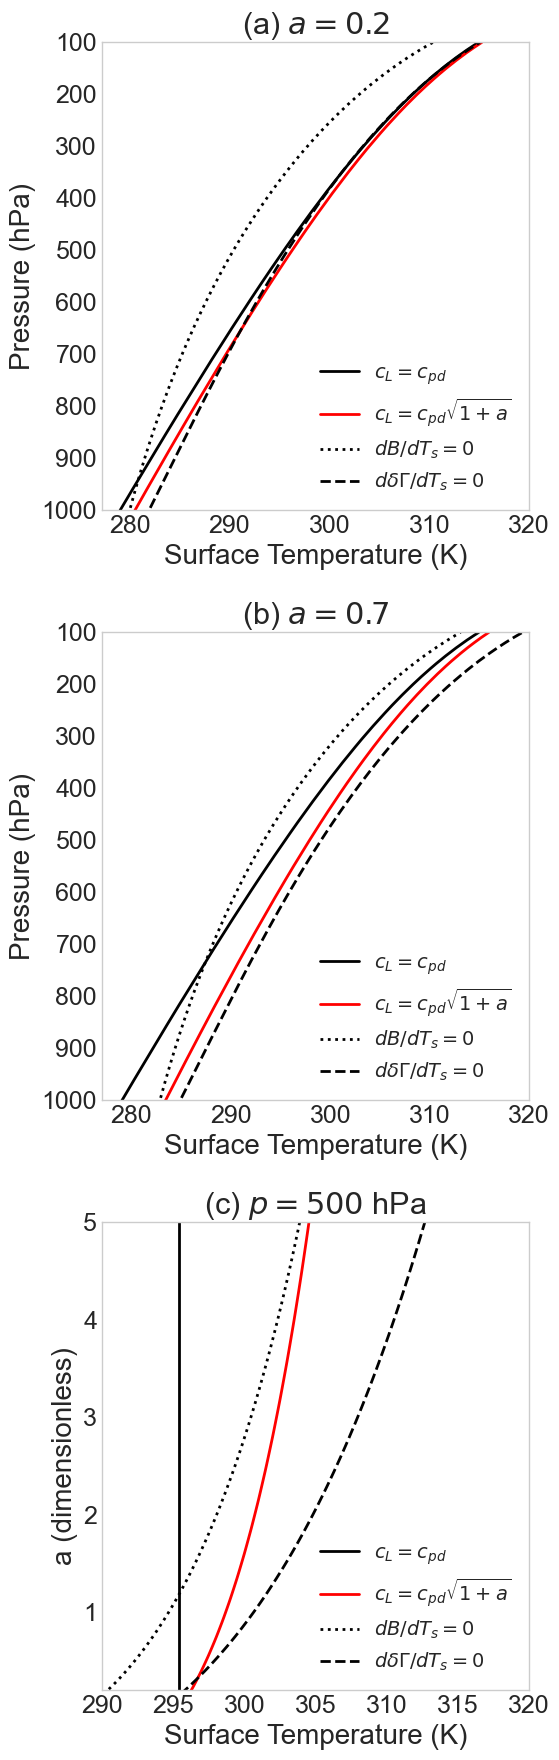

Figure 6 saved as fig-6.png


In [4]:
# ==============================================================================
# --- 5. Plotting (Figure 6 - Combined) ---
# ==============================================================================

print("--- 5. Generating Figure 6 (Combined) ---")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 22,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 14
})

# Create 3x1 subplot grid
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 18))

# --- Panel (a): p vs Ts (a=0.2) ---
ax1.plot(Ts_peak_romps_a, p_grid_a_hpa, '-', color='black', lw=2,
        label=r'$c_L = c_{pd}$')
ax1.plot(Ts_peak_derived_a, p_grid_a_hpa, '-', color='red', lw=2,
        label=r'$c_L = c_{pd}\sqrt{1+a}$')
ax1.plot(Ts_peak_actual_B_a, p_grid_a_hpa, ':', color='black', lw=2,
        label=r'$dB/dT_s = 0$')
ax1.plot(Ts_peak_integrand_a, p_grid_a_hpa, '--', color='black', lw=2,
        label=r'$d\delta\Gamma/dT_s = 0$')

ax1.set_xlabel('Surface Temperature (K)')
ax1.set_ylabel('Pressure (hPa)')
ax1.invert_yaxis()
ax1.set_xlim(right=320)
ax1.set_ylim(1000, 100)
p_levels_hpa_a = np.arange(100, 1001, 100)
ax1.set_yticks(p_levels_hpa_a)
ax1.set_title(r'(a) $a=0.2$')
ax1.legend(loc='lower right')
ax1.grid(False)

# --- Panel (b): p vs Ts (a=0.7) ---
ax2.plot(Ts_peak_romps_b, p_grid_b_hpa, '-', color='black', lw=2,
        label=r'$c_L = c_{pd}$')
ax2.plot(Ts_peak_derived_b, p_grid_b_hpa, '-', color='red', lw=2,
        label=r'$c_L = c_{pd}\sqrt{1+a}$')
ax2.plot(Ts_peak_actual_B_b, p_grid_b_hpa, ':', color='black', lw=2,
        label=r'$dB/dT_s = 0$')
ax2.plot(Ts_peak_integrand_b, p_grid_b_hpa, '--', color='black', lw=2,
        label=r'$d\delta\Gamma/dT_s = 0$')

ax2.set_xlabel('Surface Temperature (K)')
ax2.set_ylabel('Pressure (hPa)')
ax2.invert_yaxis()
ax2.set_xlim(right=320)
ax2.set_ylim(1000, 100)
p_levels_hpa_b = np.arange(100, 1001, 100)
ax2.set_yticks(p_levels_hpa_b)
ax2.set_title(r'(b) $a=0.7$')
ax2.legend(loc='lower right')
ax2.grid(False)

# --- Panel (c): a vs Ts ---
ax3.axvline(Ts_peak_romps_const_c, color='black', ls='-', lw=2,
           label=r'$c_L = c_{pd}$')
ax3.plot(Ts_peak_derived_vs_a_c, a_vals_c, color='red', ls='-', lw=2,
        label=r'$c_L = c_{pd}\sqrt{1+a}$')
ax3.plot(Ts_peak_actual_B_vs_a_c, a_vals_c, color='black', ls=':', lw=2,
        label=r'$dB/dT_s = 0$')
ax3.plot(Ts_peak_integrand_vs_a_c, a_vals_c, color='black', ls='--', lw=2,
        label=r'$d\delta\Gamma/dT_s = 0$')

ax3.set_xlabel('Surface Temperature (K)')
ax3.set_ylabel('a (dimensionless)')
# Apply user's specified limits and ticks
ax3.set_ylim(0.2, 5)
ax3.set_xlim(290, 320)
ax3.set_xticks(np.arange(290, 321, 5))
ax3.set_title(r'(c) $p=500$ hPa')
ax3.legend(loc='lower right')
ax3.grid(False)

plt.tight_layout()
plt.savefig("fig-6.png", dpi=600, bbox_inches='tight')
plt.show()
print("Figure 6 saved as fig-6.png")


In [5]:
print(np.max(np.abs(Ts_peak_derived_a-Ts_peak_romps_a)))
print(np.nanmax(np.abs(Ts_peak_derived_a-Ts_peak_integrand_a)))
print(np.nanmax(np.abs(Ts_peak_derived_a-Ts_peak_actual_B_a)))
print(np.nanmax(np.abs(Ts_peak_romps_a-Ts_peak_integrand_a)))
print(np.nanmax(np.abs(Ts_peak_romps_a-Ts_peak_actual_B_a)))

1.4877264017831067
1.3916884068791546
6.238577846954229
2.872425283921075
5.613880480523051


In [6]:
print(p_grid_a_hpa[np.nanargmax(np.abs(Ts_peak_derived_a-Ts_peak_romps_a))])
print(p_grid_a_hpa[np.nanargmax(np.abs(Ts_peak_derived_a-Ts_peak_integrand_a))])
print(p_grid_a_hpa[np.nanargmax(np.abs(Ts_peak_derived_a-Ts_peak_actual_B_a))])
print(p_grid_a_hpa[np.nanargmax(np.abs(Ts_peak_romps_a-Ts_peak_integrand_a))])
print(p_grid_a_hpa[np.nanargmax(np.abs(Ts_peak_romps_a-Ts_peak_actual_B_a))])

1000.0
995.0
360.0
995.0
320.0


In [7]:
print(Ts_peak_derived_a[p_grid_a_hpa==100]-Ts_peak_romps_a[p_grid_a_hpa==100])

[0.33199055]


In [8]:
print(np.max(np.abs(Ts_peak_derived_b-Ts_peak_romps_b)))
print(np.nanmax(np.abs(Ts_peak_derived_b-Ts_peak_integrand_b)))
print(np.nanmax(np.abs(Ts_peak_derived_b-Ts_peak_actual_B_b)))
print(np.nanmax(np.abs(Ts_peak_romps_b-Ts_peak_integrand_b)))
print(np.nanmax(np.abs(Ts_peak_romps_b-Ts_peak_actual_B_b)))

4.378426028949264
3.390265826388031
4.66126151483229
5.830870874316531
3.7363750019346185


In [9]:
print(p_grid_b_hpa[np.nanargmax(np.abs(Ts_peak_derived_b-Ts_peak_romps_b))])
print(p_grid_b_hpa[np.nanargmax(np.abs(Ts_peak_derived_b-Ts_peak_integrand_b))])
print(p_grid_b_hpa[np.nanargmax(np.abs(Ts_peak_derived_b-Ts_peak_actual_B_b))])
print(p_grid_b_hpa[np.nanargmax(np.abs(Ts_peak_romps_b-Ts_peak_integrand_b))])
print(p_grid_b_hpa[np.nanargmax(np.abs(Ts_peak_romps_b-Ts_peak_actual_B_b))])


1000.0
100.0
425.0
995.0
995.0
